<a href="https://colab.research.google.com/github/ManelSoengas/NLP/blob/main/Manel_NLP_bert_disaster_tweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Install and load the necessary libraries**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
!pip install transformers
from transformers import BertTokenizer, TFBertForSequenceClassification

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

# **Load the Dataset**.

In [ ]:
from sklearn.utils import shuffle
# Cargar datos preprocesados
#train_data = pd.read_csv('/content/EXIST2021_training.tsv', delimiter=',', encoding='latin1')
#test_data = pd.read_csv('/content/EXIST2021_test_labeled.tsv', delimiter=',', encoding='latin1')

test_data = pd.read_csv('/content/test.csv', sep=',')
train_data = pd.read_csv('/content/train.csv', sep=',')


# **Split the Dataset**

In [ ]:
from sklearn.model_selection import train_test_split

# Suponiendo que 'train_data' es tu DataFrame
train_texts, val_texts, train_labels, val_labels = train_test_split(train_data['text'], train_data['target'], test_size=.2)


# **Initialize Lists for Entry IDs and Attention Masks:**

---



**input_ids**: A list to store the tokenized IDs of each text.

**attention_masks**: A list to store attention masks, which tell BERT which parts of the text to consider and which to ignore (e.g. padding).

**Processing of Each Text**:

**For each text in texts**:

**Tokenizer.encode_plus** performs several steps:

1. Tokenize the text.
2. Adds special tokens '[CLS]' and '[SEP]' required for BERT.
3. Truncates or pads the text up to max_length.
4. Create an attention mask to distinguish real tokens from filler.

The tokenized IDs and attention masks are added to their respective lists.

**Converting Lists to PyTorch Tensors**:

**torch.cat converts** lists of IDs and attention masks into PyTorch tensors.

**Prepare the Labels**:

The labels (classification targets) are converted to a PyTorch tensor.

**Create a TensorDataset**:

A TensorDataset is created with the input IDs, attention masks, and labels, making it easy to load the data into the model.

In [ ]:
from transformers import BertTokenizer
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def prepare_data(texts, labels):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,  # Añadir '[CLS]' y '[SEP]'
                            max_length=64,            # Longitud máxima (ajustable)
                            truncation=True,          # Activar la truncación explícitamente
                            padding='max_length',     # Rellenar hasta la longitud máxima especificada
                            return_attention_mask=True,
                            return_tensors='pt',      # Retornar tensores PyTorch
                        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    # Convertir las etiquetas a una lista si es una Serie de pandas y luego a un tensor
    labels = torch.tensor(labels.tolist())

    dataset = TensorDataset(input_ids, attention_masks, labels)
    return dataset



train_dataset = prepare_data(train_texts, train_labels)
val_dataset = prepare_data(val_texts, val_labels)


In [ ]:
def prepare_data_for_test(texts):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=64,
                            truncation=True,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    dataset = TensorDataset(input_ids, attention_masks)
    return dataset

test_dataset = prepare_data_for_test(test_data['text'])


# **These DataLoaders**

---



Will take your data sets and convert them into batch sequences of data that are easy to handle during training and validation of your model. Choosing to mix training data and not validation data is a standard practice that helps train robust and well-generalized models.

In [ ]:
batch_size = 32 # Ajusta esto según tus necesidades

train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size = batch_size
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler = SequentialSampler(val_dataset),
    batch_size = batch_size
)



In [ ]:
test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=32  # Puedes ajustar esto según tus necesidades
)


# **Model BERT**

Configuring a BERT (Bidirectional Encoder Representations from Transformers) model for a classification task and preparing it for training.



In [ ]:
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch

# Configurar dispositivo para entrenamiento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2, # El número de clases en tu columna 'target'
    output_attentions = False, # Si quieres que el modelo retorne las atenciones
    output_hidden_states = False, # Si quieres que el modelo retorne los estados ocultos
)

model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

# **Training setup and model loading.**

In [ ]:

from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup
import torch
from torch.optim import AdamW

# Configurar dispositivo para entrenamiento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

model.to(device)

# Definir el número de epochs
epochs = 4

# Definir el Optimizador y el Scheduler
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8)

# Número total de pasos de entrenamiento
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# Ahora, puedes proceder con el entrenamiento del modelo como en el paso 3.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



# **The complete process of training and validating a BERT model for a classification task**.

---



It is run through a defined number of epochs and in each epoch, the model is trained with the training data set and then validated with the validation data set.



In [ ]:
epochs = 4 # Puedes ajustar el número de épocas

from sklearn.metrics import accuracy_score
import numpy as np

epochs = 4  # Puedes ajustar el número de épocas

for epoch_i in range(0, epochs):
    print('======== Época {:} / {:} ========'.format(epoch_i + 1, epochs))

    # Entrenamiento
    total_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print("  Pérdida promedio en entrenamiento: {0:.2f}".format(avg_train_loss))

    # Validación
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in validation_dataloader:
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss
        total_eval_loss += loss.item()

        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += accuracy_score(label_ids, np.argmax(logits, axis=1))

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    print("  Precisión en validación: {0:.2f}".format(avg_val_accuracy))
    print("  Pérdida promedio en validación: {0:.2f}".format(avg_val_loss))

print("Entrenamiento completo")



======== Época 1 / 4 ========
  Pérdida promedio en entrenamiento: 0.46
  Precisión en validación: 0.84
  Pérdida promedio en validación: 0.38
======== Época 2 / 4 ========
  Pérdida promedio en entrenamiento: 0.33
  Precisión en validación: 0.85
  Pérdida promedio en validación: 0.38
======== Época 3 / 4 ========
  Pérdida promedio en entrenamiento: 0.26
  Precisión en validación: 0.85
  Pérdida promedio en validación: 0.42
======== Época 4 / 4 ========
  Pérdida promedio en entrenamiento: 0.21
  Precisión en validación: 0.84
  Pérdida promedio en validación: 0.47
Entrenamiento completo


In [ ]:
model.eval()
predictions = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    predictions.extend(np.argmax(logits, axis=1))

# `predictions` ahora contiene las predicciones de clase para tu conjunto de test


In [ ]:
# Mostrar las primeras 10 predicciones
for i in range(10):
    print(f"Texto: {test_data['text'].iloc[i]}")
    print(f"Predicción: {predictions[i]}\n")


Texto: Just happened a terrible car crash
Predicción: 1

Texto: Heard about #earthquake is different cities, stay safe everyone.
Predicción: 1

Texto: there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all
Predicción: 1

Texto: Apocalypse lighting. #Spokane #wildfires
Predicción: 1

Texto: Typhoon Soudelor kills 28 in China and Taiwan
Predicción: 1

Texto: We're shaking...It's an earthquake
Predicción: 1

Texto: They'd probably still show more life than Arsenal did yesterday, eh? EH?
Predicción: 0

Texto: Hey! How are you?
Predicción: 0

Texto: What a nice hat?
Predicción: 0

Texto: Fuck off!
Predicción: 0



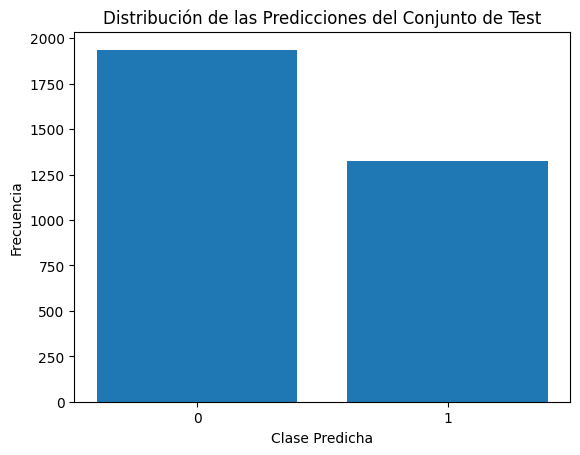

In [ ]:
import matplotlib.pyplot as plt

# Histograma de las predicciones
plt.hist(predictions, bins=np.arange(min(predictions)-0.5, max(predictions)+1.5, 1), rwidth=0.8)
plt.xticks([0, 1])
plt.xlabel('Clase Predicha')
plt.ylabel('Frecuencia')
plt.title('Distribución de las Predicciones del Conjunto de Test')
plt.show()
